# Advanced Lane Finding
## Udacity Self-Driving Car Nanodegree

### By Ethan Peacock
---

### Overview

The goal of this project is to write a software pipeline to indentify the lane
boundaries in a video with a front-facing camera on a car.  The camera<br>
calibration images, test road images, and project videos are available<br>
in this project repository:  https://github.com/udacity/CarND-Advanced-Lane-Lines

<br>
Below is a summary of the techniques used in this project.

1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform
5. Detect lane lines
6. Determine the lane curvature

---

In [1]:
# Imports
import pickle
import glob
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
# %matplotlib notebook  #  Enables interactive windows in jupyter notebook

### Compute the camera calibration matrix and distortion coefficients

./camera_cal\calibration10.jpg
./camera_cal\calibration11.jpg
./camera_cal\calibration12.jpg
./camera_cal\calibration13.jpg
./camera_cal\calibration14.jpg
./camera_cal\calibration15.jpg
./camera_cal\calibration16.jpg
./camera_cal\calibration17.jpg
./camera_cal\calibration18.jpg
./camera_cal\calibration19.jpg
./camera_cal\calibration2.jpg
./camera_cal\calibration20.jpg
./camera_cal\calibration3.jpg
./camera_cal\calibration6.jpg
./camera_cal\calibration7.jpg
./camera_cal\calibration8.jpg
./camera_cal\calibration9.jpg


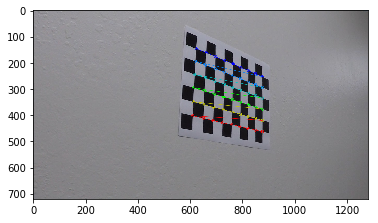

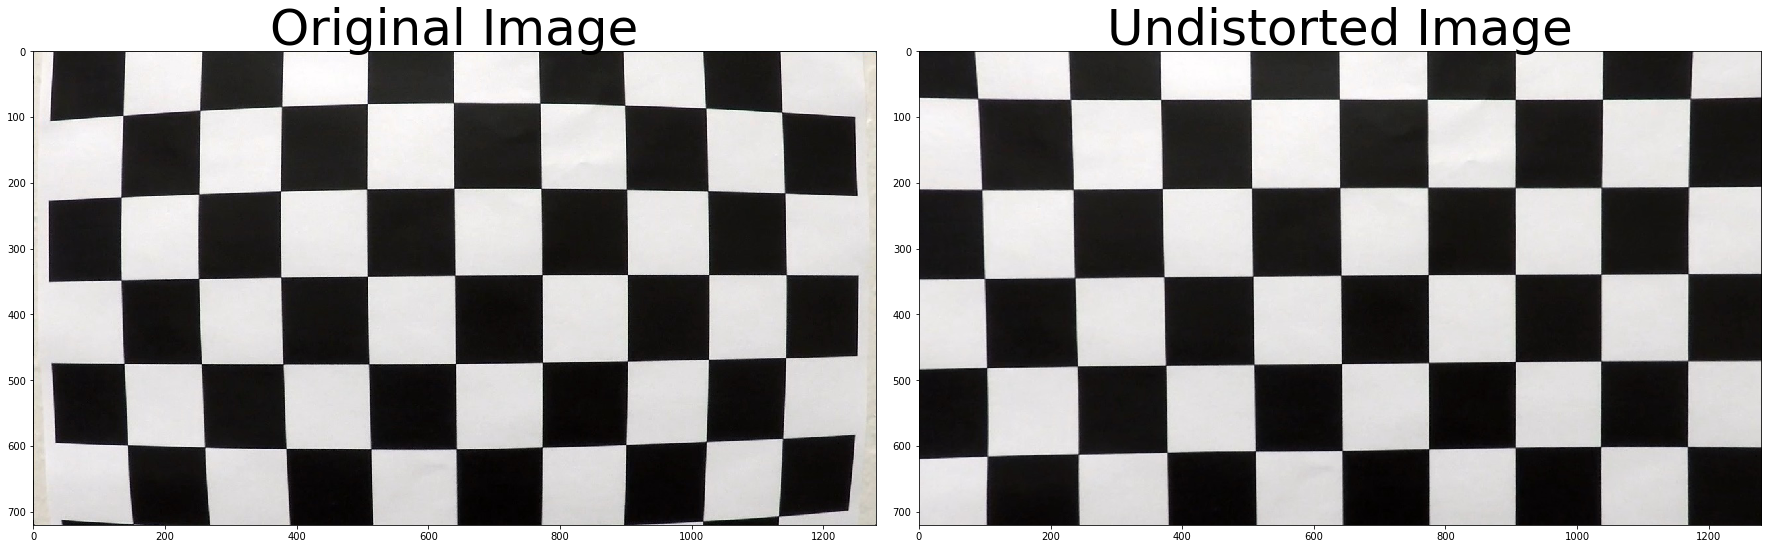

In [3]:
#  Define name of a picle file
pickle_file = "wide_dist_pickle.p"
# Read in and make a list of calibration images
images = glob.glob('./camera_cal/*')


# If a pickel file exists, then load the file
if os.path.isfile(pickle_file):
    print("A pickle file exists")
    with open(pickle_file, 'rb') as f:
        pickle_data = pickle.load(f)
        mtx = pickle_data['mtx']
        dist = pickle_data['dist']
        objpoints = pickle_data['objpoints']
        imgpoints = pickle_data['imgpoints']
        del pickle_data  # Free up memory
# If not found, start calibrating using example images
else:
    # Arrays to store object points and image points from all the imgaes
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ...., (7,5,0)
    nx = 9 # Number of inside corners of x
    ny = 6 # Number of inside corners of y

    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:6].T.reshape(-1,2) # x, y coordinates

    for fname in images:
        # Read in each image
        img = mpimg.imread(fname)
        # Convert image to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)


        # If corners are found, add object points, image points
        if ret == True:
            print(fname)
            imgpoints.append(corners)
            objpoints.append(objp)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img)

    # performs the camera calibration, image distortion correction and 
    # returns the undistorted image        
    def cal_undistort(img, objpoints, imgpoints):
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        return undist, mtx, dist

    distorted_img = mpimg.imread('camera_cal/calibration1.jpg')
    # create mtx and dist from cal_undistort function
    dst, mtx, dist = cal_undistort(distorted_img, objpoints, imgpoints)
    
    # Visualize
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(distorted_img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    # Save camera calibration result for later use in pickle file    
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    dist_pickle['objpoints'] = objpoints
    dist_pickle['imgpoints'] = imgpoints
    pickle.dump(dist_pickle, open(pickle_file, 'wb'))